In [1]:
# Import required Libraries
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import dash
from dash import dcc, html
import plotly.express as px
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

Data Scraping

In [2]:
# Add the url of AccuWeather website
url = 'https://www.accuweather.com/en/ph/baguio-city/1-262309_1_al/daily-weather-forecast/1-262309_1_al'

# Initialize the webdriver
driver = webdriver.Chrome()
driver.get(url)

In [3]:
# Find all the elements containing daily forecast data
weather_information = driver.find_elements(By.CLASS_NAME, 'daily-wrapper')
weather_data = []   # Initialize an empty list to store the data

In [4]:
# Collect the weather information variables for each day. 
# This includes date, subdate, temp_high, temp_low, condition, precip, real_feel, real_feelShade, uv_index, wind_speed
for information in weather_information:
    try:
        date = information.find_element(By.CLASS_NAME, 'date').text
        temp_high = information.find_element(By.CLASS_NAME, 'high').text
        temp_low = information.find_element(By.CLASS_NAME, 'low').text
        condition = information.find_element(By.CLASS_NAME, 'phrase').text
        precip = information.find_element(By.CLASS_NAME, 'precip').text
        real_feel = information.find_element(By.XPATH, ".//p[contains(text(), 'RealFeel')]/span[@class='value']").text
        real_feelShade = information.find_element(By.XPATH, ".//p[contains(text(), 'RealFeel Shade™')]/span[@class='value']").text
        uv_index = information.find_element(By.XPATH, ".//p[contains(text(), 'Max UV Index')]/span[@class='value']").text
        wind_speed = information.find_element(By.XPATH, ".//p[contains(text(), 'Wind')]/span[@class='value']").text
        
        print(date, temp_high, temp_low, condition, precip, real_feel, real_feelShade, uv_index, wind_speed)
        
        weather_data.append([date, temp_high, temp_low, condition, precip, real_feel, uv_index, wind_speed])
        
    except Exception as e:
        print(f"Error occurred: {e}")
        

Error occurred: Message: no such element: Unable to locate element: {"method":"xpath","selector":".//p[contains(text(), 'RealFeel Shade™')]/span[@class='value']"}
  (Session info: chrome=127.0.6533.72); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF74C929632+30946]
	(No symbol) [0x00007FF74C8DE3C9]
	(No symbol) [0x00007FF74C7D6FDA]
	(No symbol) [0x00007FF74C82822C]
	(No symbol) [0x00007FF74C82850C]
	(No symbol) [0x00007FF74C81BCDC]
	(No symbol) [0x00007FF74C84CAAF]
	(No symbol) [0x00007FF74C81BBB6]
	(No symbol) [0x00007FF74C84CC80]
	(No symbol) [0x00007FF74C86B041]
	(No symbol) [0x00007FF74C84C813]
	(No symbol) [0x00007FF74C81A6E5]
	(No symbol) [0x00007FF74C81B021]
	GetHandleVerifier [0x00007FF74CA5F83D+1301229]
	GetHandleVerifier [0x00007FF74CA6BDB7+1351783]
	GetHandleVerifier [0x00007FF74CA62A03+1313971]
	GetHandleVerifier [0x00007FF74C95DD06+245

In [5]:
# Write the collected weather variables to a CSV file named 'weather_data.csv'
with open('weather_data.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'High Temperature', 'Low Temperature', 'Condition', 'Precipitation Probability', 'Real Feel', 'UV Index', 'Wind Speed'])
    writer.writerows(weather_data)

Data Cleaning

In [6]:
#Load the Dataset to prepare it for data cleaning
file_path = 'weather_data.csv'

df = pd.read_csv(file_path)

In [7]:
# Convert the weather variables columns into integers using str.extract
df['High Temperature'] = df['High Temperature'].str.extract(r'(\d+)').astype(int)
df['Low Temperature'] = df['Low Temperature'].str.extract(r'(\d+)').astype(int)
df['Precipitation Probability'] = df['Precipitation Probability'].str.extract(r'(\d+)').astype(int)
df['Real Feel'] = df['Real Feel'].str.extract(r'(\d+)').astype(int)
df['UV Index'] = df['UV Index'].str.extract(r'(\d+)').astype(int)
df['Wind Speed'] = df['Wind Speed'].str.extract(r'(\d+)').astype(int)

In [8]:
# Drop the Condition Column from the dataset
df.drop(columns=['Condition'], inplace=True)

In [9]:
# Convert the Date column into proper datetime format
df['Date'] = pd.to_datetime(df['Date'].str.split('\n').str[1] + '/2024', format='%m/%d/%Y')

print(df['Date'])

0    2024-07-28
1    2024-07-29
2    2024-07-30
3    2024-07-31
4    2024-08-01
5    2024-08-02
6    2024-08-03
7    2024-08-04
8    2024-08-05
9    2024-08-06
10   2024-08-07
11   2024-08-08
12   2024-08-09
13   2024-08-10
14   2024-08-11
15   2024-08-12
16   2024-08-13
17   2024-08-14
18   2024-08-15
19   2024-08-16
20   2024-08-17
21   2024-08-18
22   2024-08-19
23   2024-08-20
24   2024-08-21
25   2024-08-22
26   2024-08-23
27   2024-08-24
28   2024-08-25
29   2024-08-26
30   2024-08-27
31   2024-08-28
32   2024-08-29
33   2024-08-30
34   2024-08-31
35   2024-09-01
36   2024-09-02
37   2024-09-03
38   2024-09-04
39   2024-09-05
40   2024-09-06
41   2024-09-07
42   2024-09-08
43   2024-09-09
Name: Date, dtype: datetime64[ns]


In [10]:
# Save the cleaned data to a new CSV file named 'cleaned_weather_data.csv'
cleaned_file_path = 'cleaned_weather_data.csv'
df.to_csv(cleaned_file_path, index=False)
print("Cleaned data saved to", cleaned_file_path)

Cleaned data saved to cleaned_weather_data.csv


Data Visualization

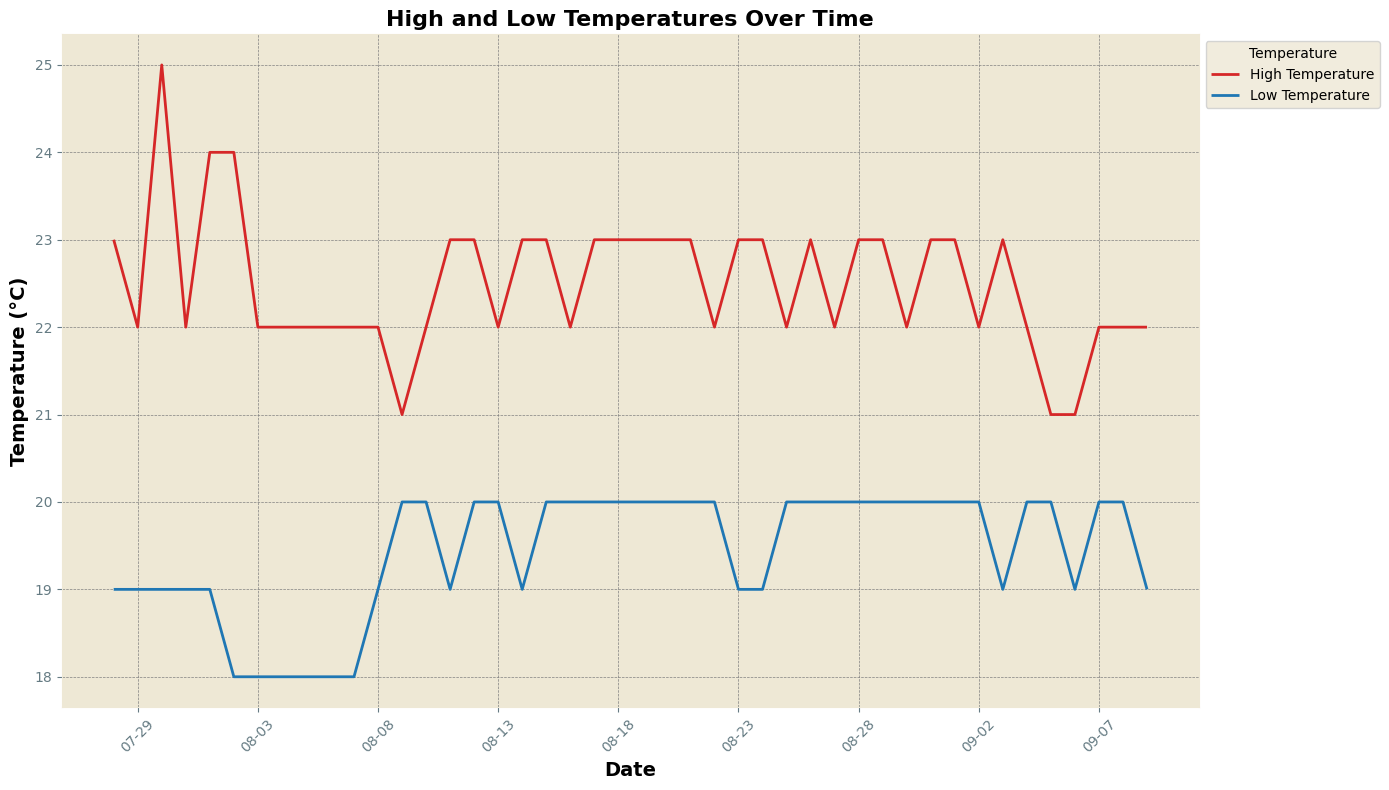

In [11]:
# This it the data visalization for Temperature over Time.
# Set the figure size. We will set it to 14 by 8 inches but it may be adjusted.
plt.figure(figsize=(14, 8)) 

# Style Configurations for better contrast
plt.style.use('Solarize_Light2')

# Plot data as a line chart. Customize plot data by color and line width
plt.plot(df['Date'], df['High Temperature'], color='tab:red', label='High Temperature', linewidth=2)
plt.plot(df['Date'], df['Low Temperature'], color='tab:blue', label='Low Temperature', linewidth=2)

# Customize labels and title with font size and weight
plt.xlabel('Date', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Temperature (°C)', fontsize=14, fontweight='bold', color='black')
plt.title('High and Low Temperatures Over Time', fontsize=16, fontweight='bold', color='black')

# Format the x-axis with date formatting and major ticks every n days where n = 5. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45)

# Legend Configurations
plt.legend(title='Temperature', loc='upper left', bbox_to_anchor=(1, 1))

# Grid Configurations
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

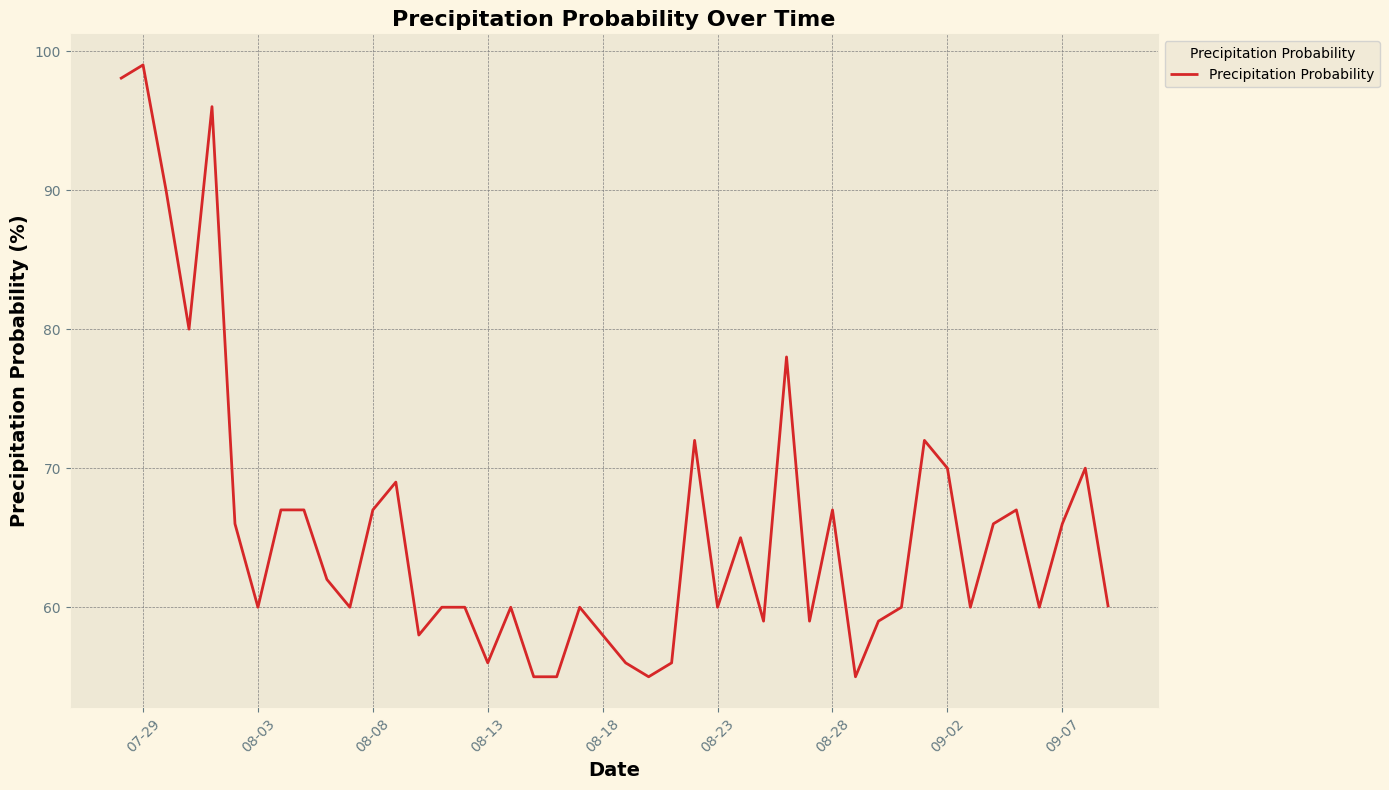

In [12]:
# This it the data visalization for Precipitation Probability over Time.
# Set the figure size. We will set it to 14 by 8 inches but it may be adjusted.
plt.figure(figsize=(14, 8)) 

# Style Configurations for better contrast
plt.style.use('Solarize_Light2')

# Plot data as a line chart. Customize plot data by color and line width
plt.plot(df['Date'], df['Precipitation Probability'], color='tab:red', label='Precipitation Probability', linewidth=2)

# Customize labels and title with font size and weight
plt.xlabel('Date', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Precipitation Probability (%)', fontsize=14, fontweight='bold', color='black')
plt.title('Precipitation Probability Over Time', fontsize=16, fontweight='bold', color='black')

# Format the x-axis with date formatting and major ticks every n days where n = 5. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45)

# Legend Configurations
plt.legend(title='Precipitation Probability', loc='upper left', bbox_to_anchor=(1, 1))

# Grid Configurations
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

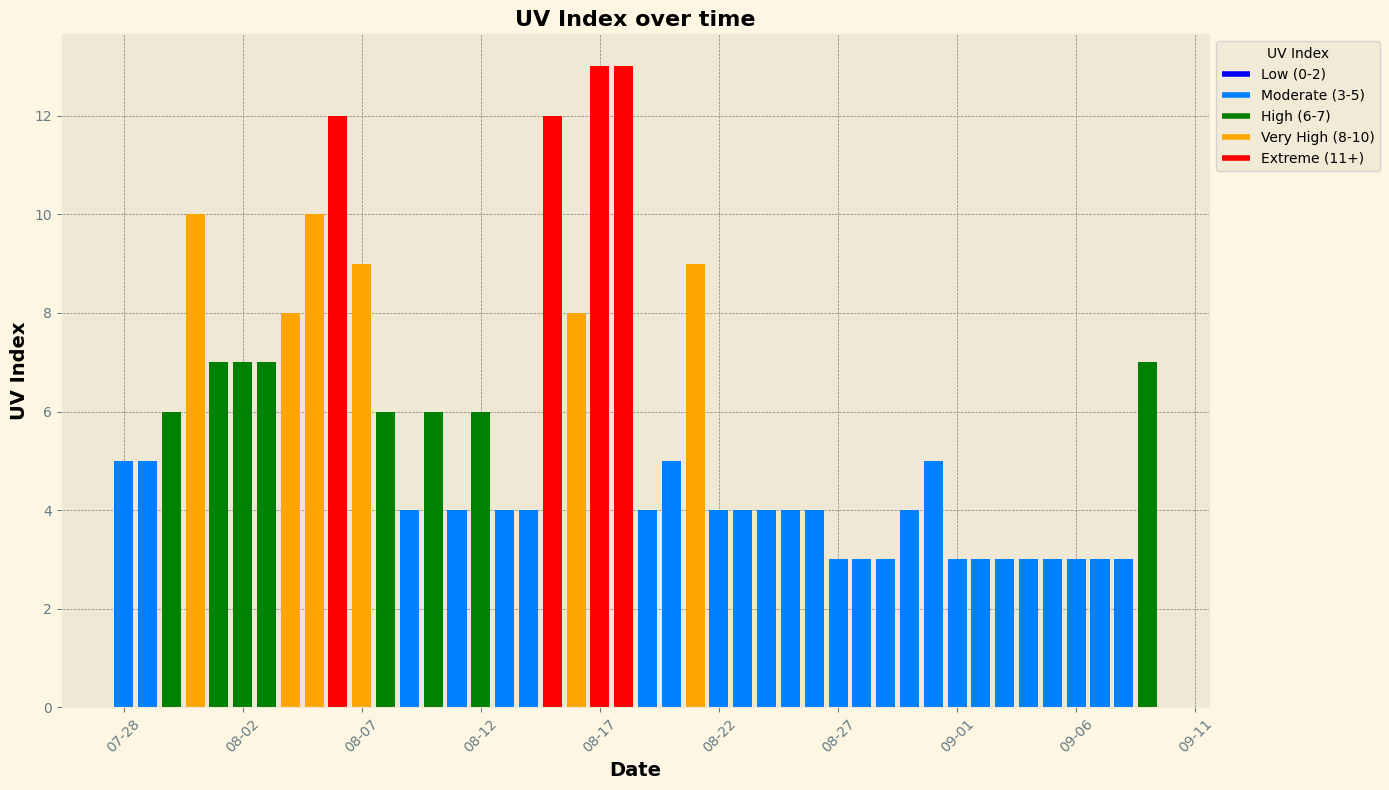

In [13]:
# This is the data visualization for UV Index over Time. 
# Assign colors based on the UV Index value. This information is based on the UV Index scale of WHO.
def uv_color(uv_index):
    if uv_index <= 2:
        return 'blue'
    elif uv_index <= 5:
        return '#007FFF'
    elif uv_index <= 7:
        return 'green'
    elif uv_index <= 10:
        return 'orange'
    else:
        return 'red'

colors = df['UV Index'].apply(uv_color)

# Set the figure size. We will set it to 14 by 8 inches but it may be adjusted.
plt.figure(figsize=(14, 8))

# We will use a bar chart. Customize plot data by color and line width.
plt.bar(df['Date'], df['UV Index'], color=colors, label='UV Index', linewidth=2)

# Labels and title configuration
plt.xlabel('Date', fontsize=14, fontweight='bold', color='black')
plt.ylabel('UV Index', fontsize=14, fontweight='bold', color='black')
plt.title('UV Index over time', fontsize=16, fontweight='bold', color='black')

# Format the x-axis with date formatting and major ticks every n days where n = 5. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a title and adjust its location with color black
legend_labels = {
    'blue': 'Low (0-2)',
    '#007FFF': 'Moderate (3-5)',
    'green': 'High (6-7)',
    'orange': 'Very High (8-10)',
    'red': 'Extreme (11+)'
}

# Legend Configurations
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_labels]
plt.legend(handles, legend_labels.values(), title='UV Index', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Grid Configurations
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

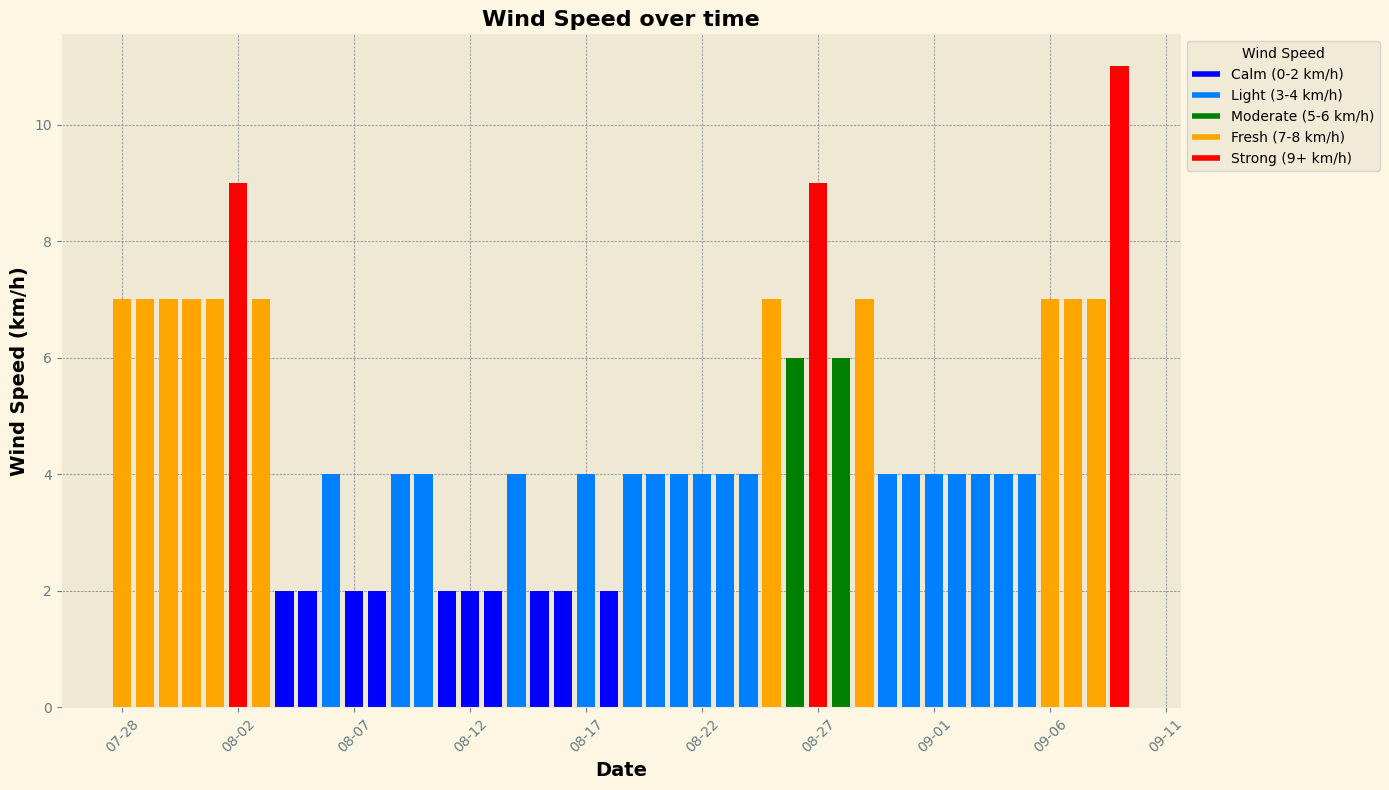

In [14]:
# This is the data visualization for Wind Speed over Time.
# Assign colors based on Wind Speed value.
def wind_speed_color(wind_speed):
    if wind_speed <= 2:
        return 'blue'  # Calm
    elif wind_speed <= 4:
        return '#007FFF'  # Light
    elif wind_speed <= 6:
        return 'green'  # Moderate
    elif wind_speed <= 8:
        return 'orange'  # Fresh
    else:
        return 'red'  # Strong

colors = df['Wind Speed'].apply(wind_speed_color)

# Set the figure size. We will set it to 14 by 8 inches but it may be adjusted.
plt.figure(figsize=(14, 8))

# Plot the data with the assigned colors
plt.bar(df['Date'], df['Wind Speed'], color=colors, label='Wind Speed', linewidth=2)

# Labels and title configuration
plt.xlabel('Date', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Wind Speed (km/h)', fontsize=14, fontweight='bold', color='black')
plt.title('Wind Speed over time', fontsize=16, fontweight='bold', color='black')

# Format the x-axis with date formatting and major ticks every n days where n = 5. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a title and adjust its location with color black
legend_labels = {
    'blue': 'Calm (0-2 km/h)',
    '#007FFF': 'Light (3-4 km/h)',
    'green': 'Moderate (5-6 km/h)',
    'orange': 'Fresh (7-8 km/h)',
    'red': 'Strong (9+ km/h)'
}

# Legend Configurations
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_labels]
plt.legend(handles, legend_labels.values(), title='Wind Speed', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Grid Configurations
plt.grid(True, linestyle='--', color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

In [15]:
# Collect the data to be used for correlation analysis
data = {
    'Date': df['Date'],
    'High Temperature': df['High Temperature'],
    'Low Temperature': df['Low Temperature'],
    'Precipitation Probability': df['Precipitation Probability'],
    'UV Index': df['UV Index'],
    'Wind Speed': df['Wind Speed']
}

df = pd.DataFrame(data)

# Calculate the correlation matrix
correlation_matrix = df.corr()

print(correlation_matrix)

                               Date  High Temperature  Low Temperature  \
Date                       1.000000         -0.262748         0.553261   
High Temperature          -0.262748          1.000000        -0.060462   
Low Temperature            0.553261         -0.060462         1.000000   
Precipitation Probability -0.413568          0.221527        -0.208986   
UV Index                  -0.500349          0.133941        -0.326635   
Wind Speed                 0.147367          0.090881        -0.080283   

                           Precipitation Probability  UV Index  Wind Speed  
Date                                       -0.413568 -0.500349    0.147367  
High Temperature                            0.221527  0.133941    0.090881  
Low Temperature                            -0.208986 -0.326635   -0.080283  
Precipitation Probability                   1.000000 -0.084850    0.351447  
UV Index                                   -0.084850  1.000000   -0.259105  
Wind Speed         

In [16]:
# Calculate the average temperature
df['Average Temperature'] = (df['High Temperature'] + df['Low Temperature']) / 2

# Separate features and target variable. Target variable is 'Average Temperature'
X = df[['Date', 'Precipitation Probability', 'UV Index', 'Wind Speed']]
y = df['Average Temperature']

# Convert the 'Date' column into numeric to make it suitable for the model
X['Date'] = X['Date'].map(pd.Timestamp.toordinal)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RF Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                     Feature  Importance
0                       Date    0.553670
2                   UV Index    0.199160
1  Precipitation Probability    0.183772
3                 Wind Speed    0.063399


C:\Users\Achilles\AppData\Local\Temp\ipykernel_38712\1310606118.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date'] = X['Date'].map(pd.Timestamp.toordinal)


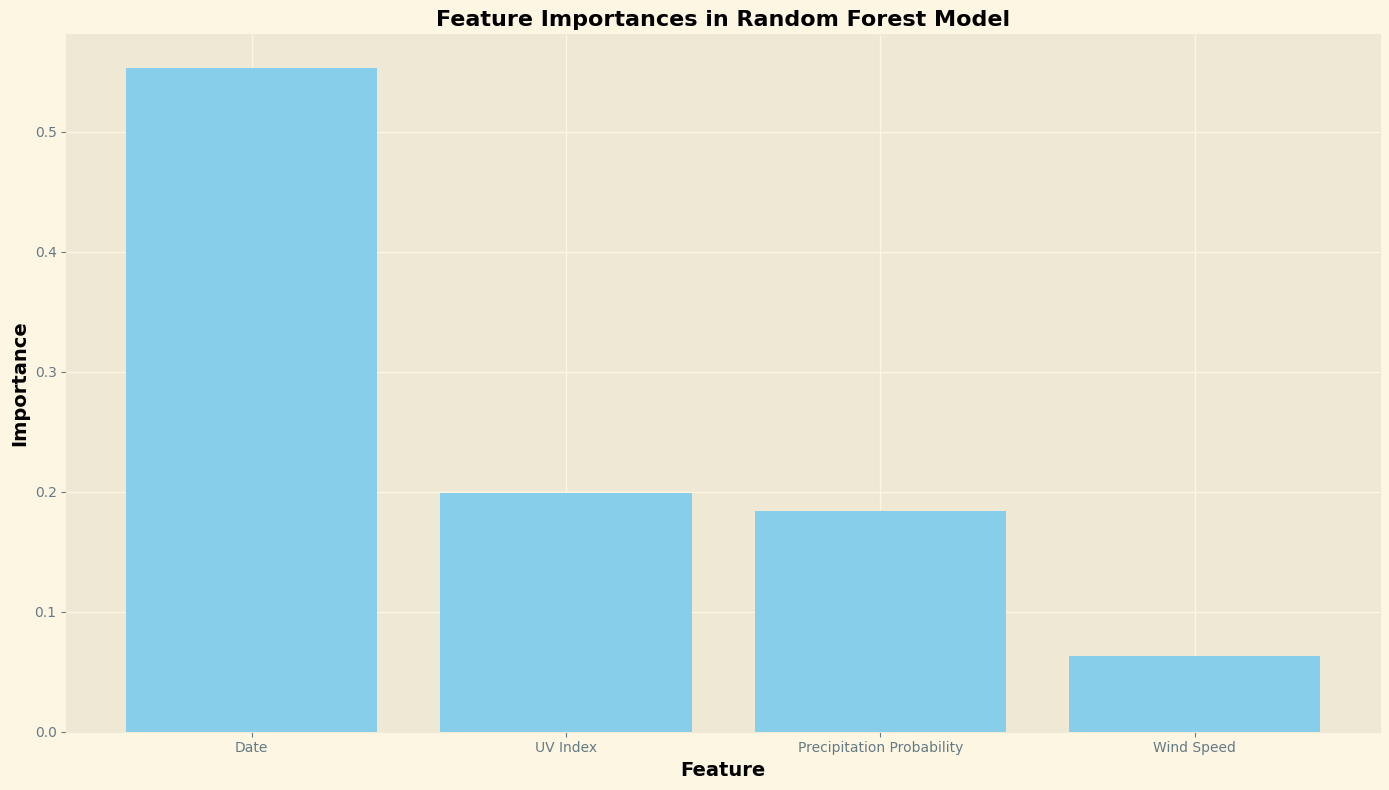

In [17]:
# Plot feature importances
plt.figure(figsize=(14, 8))
plt.style.use('Solarize_Light2')
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Importance', fontsize=14, fontweight='bold', color='black')
plt.title('Feature Importances in Random Forest Model', fontsize=16, fontweight='bold', color='black')
plt.tight_layout()
plt.show()

In [18]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

In [19]:
# Load the data
df = pd.read_csv('cleaned_weather_data.csv')

In [23]:
# Load the cleaned dataset
df = pd.read_csv(cleaned_file_path)

# Set the color functions for the graphs
df['UV Color'] = df['UV Index'].apply(uv_color)
df['Wind Speed Color'] = df['Wind Speed'].apply(wind_speed_color)

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the layout of the app
app.layout = dbc.Container([
    html.H1("Weather Data Dashboard"),
    
    # Dropdown Configuration for selecting the graph to display
    dcc.Dropdown(
        id='graph-dropdown',
        options=[
            {'label': 'Temperature over Time', 'value': 'temperature'},
            {'label': 'Precipitation over Time', 'value': 'precipitation'},
            {'label': 'UV Index over Time', 'value': 'uv_index'},
            {'label': 'Wind Speed over Time', 'value': 'wind_speed'},
            {'label': 'Correlation Matrix', 'value': 'correlation'},
            {'label': 'Feature Importance', 'value': 'feature_importance'},
            
        ],
        value='temperature', 
        clearable=False
    ),
    
    # Graph to display based on the weather variables
    dcc.Graph(id='weather-graph'),
    
    # Div configurations for displaying the interpretation
    html.Div(id='interpretation', style={'margin-top': '20px'})
])

# Define callback for updating the graph
@app.callback(
    [Output('weather-graph', 'figure'),
     Output('interpretation', 'children')],
    [Input('graph-dropdown', 'value')]
)

# Define the function to update the graph
def update_graph(selected_graph):
    interpretation_text = ""
    
    # Temperature Graph Configuration
    if selected_graph == 'temperature':
        fig = px.line(df, x='Date', y=['High Temperature', 'Low Temperature'],
                      labels={'value': 'Temperature (°C)', 'Date': 'Date'},
                      title='High and Low Temperatures Over Time')
        interpretation_text = "This graph shows the variations in high and low temperatures over time. " \
                              "It can help identify patterns and trends in temperature changes."
                              
    # Precipitation Probability Graph Configuration
    elif selected_graph == 'precipitation':
        fig = px.line(df, x='Date', y='Precipitation Probability',
                      labels={'value': 'Precipitation (%)', 'Date': 'Date'},
                      title='Precipitation over Time')
        interpretation_text = "This graph displays the probability of precipitation over time. " \
                              "Higher values indicate a greater likelihood of rain or other forms of precipitation."
                              
    # UV Index Graph Configuration
    elif selected_graph == 'uv_index':
        fig = px.bar(df, x='Date', y='UV Index',
                     labels={'value': 'UV Index', 'Date': 'Date'},
                     title='UV Index Over Time',
                     text_auto=True,
                     color=df['UV Color'],  # Use the color column for bar colors
                     color_discrete_map='identity')  # Use identity map to use the exact colors provided
        fig.update_layout(showlegend=True, legend_title_text='UV Index Levels')
        interpretation_text = html.Div([
            "This bar chart illustrates the UV Index levels over time. Different colors represent varying levels of UV radiation:",
            html.Ul([
                html.Li("Low (0-2): ", style={'color': 'blue'}),
                html.Li("Moderate (3-5): ", style={'color': '#007FFF'}),
                html.Li("High (6-7): ", style={'color': 'green'}),
                html.Li("Very High (8-10): ", style={'color': 'orange'}),
                html.Li("Extreme (11+): ", style={'color': 'red'}),
            ])
        ])
        
    # Wind Speed Graph Configuration
    elif selected_graph == 'wind_speed':
        fig = px.bar(df, x='Date', y='Wind Speed',
                     labels={'value': 'Wind Speed (m/s)', 'Date': 'Date'},
                     title='Wind Speed Over Time',
                     text_auto=True,
                     color=df['Wind Speed Color'],  # Use the color column for bar colors
                     color_discrete_map='identity')
        interpretation_text = html.Div([
            "This bar chart shows wind speed over time. The colors indicate the intensity of the wind:",
            html.Ul([
                html.Li("Calm (0-2 m/s): ", style={'color': 'blue'}),
                html.Li("Light (3-4 m/s): ", style={'color': '#007FFF'}),
                html.Li("Moderate (5-6 m/s): ", style={'color': 'green'}),
                html.Li("Fresh (7-8 m/s): ", style={'color': 'orange'}),
                html.Li("Strong (9+ m/s): ", style={'color': 'red'}),
            ])
        ])
        
    # Correlation Graph Configuration
    elif selected_graph == 'correlation':
        fig = px.imshow(correlation_matrix,
                        labels=dict(color="Correlation"),
                        title='Correlation Matrix Heatmap',
                        text_auto=True)
        interpretation_text = "The correlation matrix heatmap visualizes the relationships between different weather variables. " \
                              "Values closer to 1 or -1 indicate strong correlations, either positive or negative, respectively." 
                                
    # Feature Importance Graph Configuration
    elif selected_graph == 'feature_importance':
        fig = px.bar(feature_importance_df, x='Feature', y='Importance',
                     labels={'Importance': 'Importance', 'Feature': 'Feature'},
                     title='Feature Importances in Random Forest Model')
        fig.update_layout(xaxis_title='Feature', yaxis_title='Importance', xaxis_tickangle=-45)
        interpretation_text = "This bar chart shows the importance of each feature in predicting the average temperature. " \
                              "Features with higher values are more significant in the model's predictions."
    
    
    return fig, interpretation_text

# Run the app
if __name__ == '__main__':
    app.run_server(port=4080)
